In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import yaml
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

#!pip install "git+https://github.com/yandex-research/shifts.git#egg=ysdc_dataset_api&subdirectory=sdc"
import ysdc_dataset_api
from ysdc_dataset_api.utils import get_file_paths, scenes_generator, transform_2d_points
from dataset import CustomDataset
from ysdc_dataset_api.features import FeatureRenderer
from trajectory_set_generator import FixedGenerator
from covernet_backbone import ResNetBackbone, MobileNetBackbone
from covernet_predictor import CoverNet
from metrics import ConstantLatticeLoss, ADE, FDE
from train import train


%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/mohammed/anaconda3/envs/covernet/lib/python3.9/site-packages/ysdc_dataset_api/utils/transform.py:90: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  res = transform @ ph
/home/mohammed/anaconda3/envs/covernet/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


### Rendering

In [3]:
with open("yandex_shifts_covernet.yaml", "r") as stream:
    config = yaml.safe_load(stream)
    renderer_config = config['renderer']

renderer = FeatureRenderer(renderer_config)
#renderer.to_feature_map_tf

### Data

In [59]:
root = '/mnt/Vol0/datasets/yandex_shifts/sdc/data'

dataset_path = root + '/train_pb'
prerendered_dataset_path = root + '/train_rendered'
scene_tags_fpath = root + '/train_tags.txt'

val_dataset_path = root + '/development_pb'
prerendered_val_dataset_path = root + '/development_rendered'
val_scene_tags_fpath = root + '/development_tags.txt'

save_root_path = '/hdd/CoverNet/saved_models'

past_steps = 1

def filter_stationary_trajectory(trajectory_tags_list):
    return 'kStationary' not in trajectory_tags_list

In [60]:
dataset = CustomDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producers=[renderer],
    transform_ground_truth_to_agent_frame=True,
    prerendered_dataset_path=prerendered_dataset_path,
    past_steps = past_steps,
    trajectory_tags_filter=filter_stationary_trajectory
)

388406/388406 scenes fit the filter criteria.


In [61]:
val_dataset = CustomDataset(
    dataset_path=val_dataset_path,
    scene_tags_fpath=val_scene_tags_fpath,
    feature_producers=[renderer],
    transform_ground_truth_to_agent_frame=True,
    prerendered_dataset_path=prerendered_val_dataset_path,
    past_steps = past_steps,
    div='val'
)

36605/36605 scenes fit the filter criteria.


### Visualization

In [62]:
dataset_iter = iter(dataset)
data_items = []
for i in range(350):
    data_items.append(next(dataset_iter))

In [63]:
random_index = np.random.randint(0, len(data_items))
data_item = data_items[random_index]
transformed_gt = transform_2d_points(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)

In [66]:
transformed_gt

array([[64, 63],
       [64, 63],
       [65, 63],
       [65, 63],
       [66, 63],
       [66, 64],
       [66, 64],
       [66, 64],
       [66, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64],
       [67, 64]], dtype=int32)

In [67]:
data_item['ground_truth_trajectory']

array([[ 4.9072266e-01, -1.5625000e-02],
       [ 9.1503906e-01, -2.1484375e-02],
       [ 1.3481445e+00, -3.6621094e-02],
       [ 1.7421875e+00, -2.4414062e-02],
       [ 2.0190430e+00, -2.4414062e-03],
       [ 2.2988281e+00,  1.9042969e-02],
       [ 2.5996094e+00,  4.1503906e-02],
       [ 2.8461914e+00,  8.3496094e-02],
       [ 2.9965820e+00,  1.3671875e-01],
       [ 3.1572266e+00,  1.8554688e-01],
       [ 3.3281250e+00,  2.1728516e-01],
       [ 3.4897461e+00,  2.7099609e-01],
       [ 3.5668945e+00,  2.9150391e-01],
       [ 3.5747070e+00,  2.9833984e-01],
       [ 3.5917969e+00,  2.9687500e-01],
       [ 3.6137695e+00,  2.9687500e-01],
       [ 3.5834961e+00,  3.0859375e-01],
       [ 3.5708008e+00,  3.3544922e-01],
       [ 3.5991211e+00,  3.4716797e-01],
       [ 3.5703125e+00,  3.5058594e-01],
       [ 3.5512695e+00,  4.1162109e-01],
       [ 3.5473633e+00,  3.9648438e-01],
       [ 3.6528320e+00,  3.3789062e-01],
       [ 3.5996094e+00,  3.2617188e-01],
       [ 3.60205

In [68]:
data_item['feature_maps'].shape

(17, 128, 128)

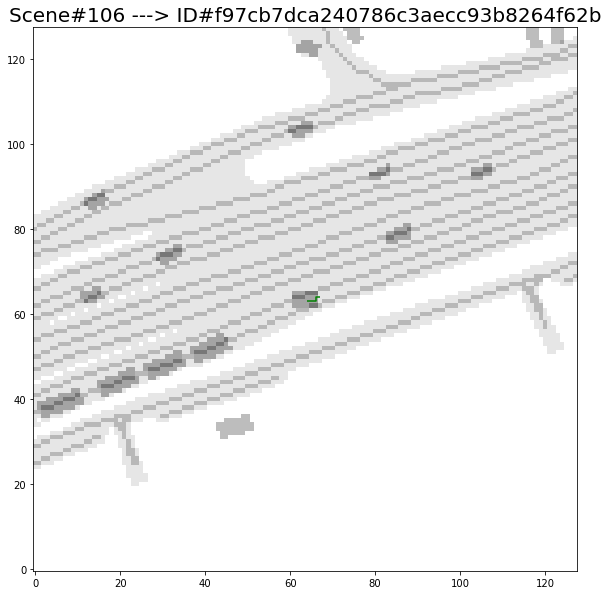

In [69]:
# Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
plt.figure(figsize=(10, 10))
plt.title(f'Scene#{random_index} ---> ID#'+data_item['scene_id'], fontsize=20)
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)
ax = plt.gca()
ax.add_collection(mc.LineCollection([transformed_gt], color='green'))
plt.show()

### Trajectory Set Generator

In [ ]:
fg = FixedGenerator(load_fpth='epsilon_2_k_64.pkl')
traj_set = fg.traj_set

### Model

In [ ]:
feature_maps = torch.tensor(data_item['feature_maps'])
mobilenet_weights_file_path = f'{save_root_path}/model-seed-10-epoch-57-trimmed.pt'

### Model Training

#### minimal pipeline

In [ ]:
backbone = ResNetBackbone(feature_maps.shape, pretrained=True)
model = CoverNet(backbone=backbone, asv_dim=5*past_steps)

val_dataloader = DataLoader(val_dataset, batch_size=256)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
criterion = ConstantLatticeLoss(traj_set)

model.train()

for item in val_dataloader:

    hdmap = item['feature_maps']
    agent_state_vector = item['agent_state_vector']
    ground_truth = item['ground_truth_trajectory']

    optimizer.zero_grad()
    preds = model(hdmap, agent_state_vector)
    loss = criterion(preds, ground_truth)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.)
    optimizer.step()

    print(loss.item())

#### main pipeline

In [ ]:
resnet_backbone = ResNetBackbone(feature_maps.shape, pretrained=True)
mobilenet_backbone = MobileNetBackbone(feature_maps.shape, weights_path=mobilenet_weights_file_path)
covernet_model = CoverNet(backbone=resnet_backbone, asv_dim=5*past_steps)
loss, val_loss = train(dataset, val_dataset, covernet_model, ConstantLatticeLoss(traj_set),
      f'{save_root_path}/fixed_eps_2_k_64_resnet50')

### Model Evaluation

In [ ]:
def _init_fn(worker_id):
    np.random.seed(42)
    
def evaluate(model, val_dataloader, criterion):
    model.eval()
    cum_loss = 0
    
    with torch.no_grad():
        for item in val_dataloader:
            hdmap = item['feature_maps'].to(device)
            agent_state_vector = item['agent_state_vector'].to(device)
            ground_truth = item['ground_truth_trajectory'].to(device)
            
            output = model(hdmap, agent_state_vector)
            loss = criterion(output, ground_truth)
            cum_loss += loss.item()
    
    return cum_loss / len(val_dataloader)

model = torch.load(f'{save_root_path}/fixed_eps_2_k_64_pretrained_resnet50_seed_42.pt')
val_dataloader = DataLoader(val_dataset, batch_size=256, worker_init_fn=_init_fn, pin_memory=True)
evaluate(model, val_dataloader, ADE(traj_set))

### Visualization

In [ ]:
def plot(train_losses, val_losses):
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss', fontsize=18)
    ax1.set_xlabel("Iteration", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14)

    ax2.plot(val_losses)
    ax2.set_title('Validation Loss', fontsize=18)
    ax2.set_xlabel("Iteration", fontsize=14)
    ax2.set_ylabel("Val Loss", fontsize=14)

    fig.tight_layout()
    plt.show()

In [ ]:
plot(loss, val_loss)